## Import necessary libraries

In [204]:
import os
os.chdir("../SadOrHappy_ML_Madcamp_Week3")

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, \
                          Flatten, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Input, Sequential
from keras.applications.resnet50 import ResNet50
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

## Define hyperparameters

In [205]:
BATCH_SIZE = 32
EPOCHS = 30
IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_OUTPUTS = 5
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5
L2_WEIGHT_DECAY = 1e-6

The dataset has following directory structure:

<pre>
<b>dataset</b>
|__ <b>train</b>
    |______ <b>angry</b>: [0.jpg, 1.jpg, 10.jpg, ...]
    |______ <b>happy</b>: [100.jpg, 10000.jpg, 10001.jpg, ...]
    |______ <b>neutral</b>: [1000.jpg, 10003.jpg, 10014.jpg, ...]
    |______ <b>sad</b>: [10006.jpg, 10008.jpg, 1001.jpg, ...]
    |______ <b>surprise</b>: [10007.jpg, 10009.jpg, 10011.jpg, ...]
|__ <b>validation</b>
    |______ <b>angry</b>: [10052.jpg, 10065.jpg, 10079.jpg, ....]
    |______ <b>happy</b>: [10019.jpg, 10023.jpg, 10074.jpg, ...]
    |______ <b>neutral</b>: [10033.jpg, 10048.jpg, 10068.jpg, ...]
    |______ <b>sad</b>: [10004.jpg, 1003.jpg, 10031.jpg, ...]
    |______ <b>surprise</b>: [10056.jpg, 10097.jpg, 10162.jpg, ...]
</pre>

In [206]:
train_dir = os.path.join("./dataset", "train")
validation_dir = os.path.join("./dataset", "validation")

train_angry_dir = os.path.join(train_dir, "angry")
train_happy_dir = os.path.join(train_dir, "happy")
train_neutral_dir = os.path.join(train_dir, "neutral")
train_sad_dir = os.path.join(train_dir, "sad")
train_surprise_dir = os.path.join(train_dir, "surprise")

validation_angry_dir = os.path.join(validation_dir, "angry")
validation_happy_dir = os.path.join(validation_dir, "happy")
validation_neutral_dir = os.path.join(validation_dir, "neutral")
validation_sad_dir = os.path.join(validation_dir, "sad")
validation_surprise_dir = os.path.join(validation_dir, "surprise")

num_angry_tr = len(os.listdir(train_angry_dir))
num_happy_tr = len(os.listdir(train_happy_dir))
num_neutral_tr = len(os.listdir(train_neutral_dir))
num_sad_tr = len(os.listdir(train_sad_dir))
num_surprise_tr = len(os.listdir(train_surprise_dir))

num_angry_val = len(os.listdir(validation_angry_dir))
num_happy_val = len(os.listdir(validation_happy_dir))
num_neutral_val = len(os.listdir(validation_neutral_dir))
num_sad_val = len(os.listdir(validation_sad_dir))
num_surprise_val = len(os.listdir(validation_surprise_dir))

total_train = num_angry_tr + num_happy_tr + num_neutral_tr + num_sad_tr + num_surprise_tr
total_val = num_angry_val + num_happy_val + num_neutral_val + num_sad_val + num_surprise_val

# debug
print('total # of training set :', total_train)
print('total # of train_angry :', num_angry_tr)
print('total # of train_happy :', num_happy_tr)
print('total # of train_neutral :', num_neutral_tr)
print('total # of train_sad :', num_sad_tr)
print('total # of train_surprise :', num_surprise_tr, "\n")

print('total # of validation set :', total_val)
print('total # of validation_angry :', num_angry_val)
print('total # of validation_happy :', num_happy_val)
print('total # of validation_neutral :', num_neutral_val)
print('total # of validation_sad :', num_sad_val)
print('total # of validation_surprise :', num_surprise_val)

total # of training set : 107923
total # of train_angry : 16620
total # of train_happy : 28604
total # of train_neutral : 34234
total # of train_sad : 17145
total # of train_surprise : 11320 

total # of validation set : 37805
total # of validation_angry : 2893
total # of validation_happy : 12758
total # of validation_neutral : 12860
total # of validation_sad : 5551
total # of validation_surprise : 3743


## Preprocess the dataset

In [207]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [208]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = train_dir,
    color_mode = 'grayscale',
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = validation_dir,
    color_mode = 'grayscale',
    shuffle = False,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
  )

Found 107915 images belonging to 5 classes.
Found 37805 images belonging to 5 classes.


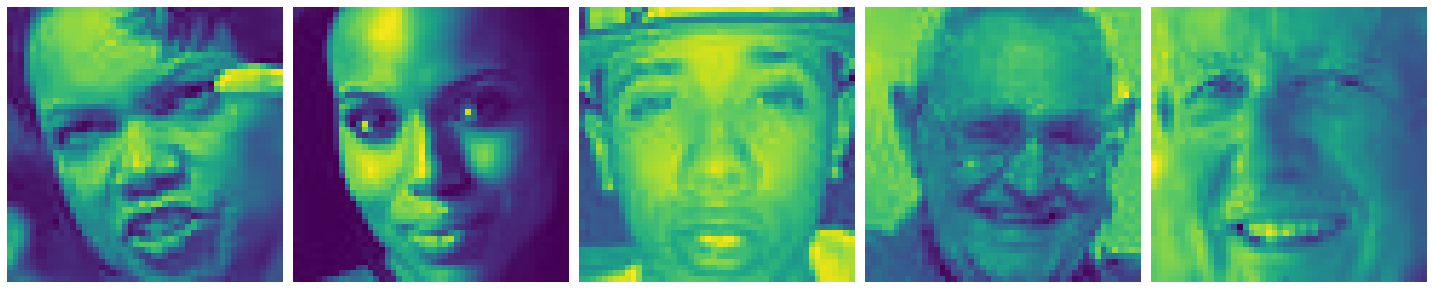

In [209]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Define model

In [210]:
def simple_cnn():
  model = Sequential()
 
  model.add(Conv2D(3, (3, 3), input_shape = (IMG_HEIGHT, IMG_WIDTH, 1), padding = 'same'))
  model.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(NUM_OUTPUTS))
  model.add(Activation('softmax'))
  return model

def resnet_fine_tuning():
  input_tensor = Input(shape = (IMG_HEIGHT, IMG_WIDTH, 1))
  x = Conv2D(3, (3, 3), padding='same')(input_tensor)
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
  x = base_model(x)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(NUM_OUTPUTS, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=x)
  return model

model = simple_cnn()
# model = resnet_fine_tuning()

optimizer = Adam(lr = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer)
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_229 (Conv2D)          (None, 48, 48, 3)         30        
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 48, 48, 128)       9728      
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 48, 48, 128)       409728    
_________________________________________________________________
batch_normalization_134 (Bat (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_131 (Dropout)        (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 24, 24, 128)     

## Train model

In [211]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount = False)

# def get_drive_path():
#   path = F"/content/gdrive/MyDrive/Colab Notebooks/weights/"
#   path += "weights_{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.h5"
#   return path

def get_local_path():
  path = os.path.join("weights/", "weights_{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.h5")
  return path

# path = get_drive_path()
path = get_local_path()
save_model_callback = ModelCheckpoint(filepath = path)

history = model.fit(
    train_data_gen,
    steps_per_epoch = total_train // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    validation_steps = total_val // BATCH_SIZE,
    callbacks = [save_model_callback],
    class_weight = {0 : 1, 1 : 1, 2 : 2, 3 : 2, 4 : 1} # 0 : angry, 1 : happy, 2 : neutral, 3 : sad, 4 : surprise
)

Epoch 1/30
3372/3372 [==============================] - 66s 20ms/step - loss: 2.2126 - accuracy: 0.3654 - val_loss: 1.4713 - val_accuracy: 0.4585
Epoch 2/30
3372/3372 [==============================] - 66s 20ms/step - loss: 1.6397 - accuracy: 0.5407 - val_loss: 1.1677 - val_accuracy: 0.5522
Epoch 3/30
3372/3372 [==============================] - 66s 20ms/step - loss: 1.4064 - accuracy: 0.6155 - val_loss: 1.1007 - val_accuracy: 0.5859
Epoch 4/30
3372/3372 [==============================] - 66s 20ms/step - loss: 1.2943 - accuracy: 0.6520 - val_loss: 1.2152 - val_accuracy: 0.5590
Epoch 5/30
3372/3372 [==============================] - 66s 20ms/step - loss: 1.2145 - accuracy: 0.6758 - val_loss: 1.0908 - val_accuracy: 0.6039
Epoch 6/30
3372/3372 [==============================] - 66s 20ms/step - loss: 1.1565 - accuracy: 0.6937 - val_loss: 1.0574 - val_accuracy: 0.6070
Epoch 7/30
3372/3372 [==============================] - 67s 20ms/step - loss: 1.1090 - accuracy: 0.7073 - val_loss: 1.0967 -

## Plot training result

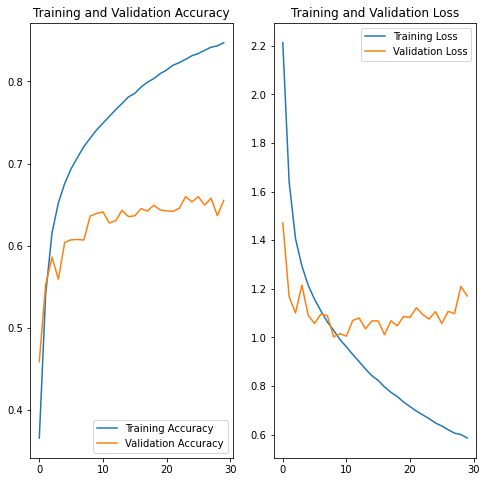

In [212]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()